# **Import necessary libraries**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, precision_recall_curve
from sklearn.decomposition import PCA
import joblib

# **Data Preprocessing**

In [ ]:
# Section 1: Load and Preview Dataset
data = pd.read_csv('/content/drive/MyDrive/CSE366-AI/Thyroid_Diff.csv')
print("Dataset Preview:")
print(data.head())
print("\nColumns in the dataset:")
print(data.columns)

# Section 2: Handle Missing Values
# Separate numeric and categorical columns
numeric_columns = data.select_dtypes(include=[np.number]).columns
categorical_columns = data.select_dtypes(include=['object']).columns

# Fill missing values for numeric columns with median
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].median())

# Fill missing values for categorical columns with mode
for column in categorical_columns:
    data[column].fillna(data[column].mode()[0], inplace=True)

# Section 3: Encode Categorical Variables
label_encoders = {}
for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

# Section 4: Separate Features and Target Variable
target_column = 'Recurred'
if target_column not in data.columns:
    raise ValueError(f"Error: The column '{target_column}' does not exist in the dataset. Available columns are: {data.columns.tolist()}")

X = data.drop(columns=[target_column])
y = data[target_column]


# **Training and Testing Sets**

In [5]:
# Section 5: Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Section 6: Standardize Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
# Section 7: Initialize Models
models = {
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(probability=True),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(),
    'Neural Network': MLPClassifier(max_iter=1000),
    'Gradient Boosting': GradientBoostingClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Naive Bayes': GaussianNB()
}

# Section 8: Train and Evaluate Models
results = {}
for name, model in models.items():
    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            roc_auc = roc_auc_score(y_test, y_pred_proba)
        else:
            y_pred_proba = None
            roc_auc = 'N/A'

        report = classification_report(y_test, y_pred, output_dict=True)

        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'roc_auc': roc_auc,
            'report': report
        }

        print(f"Model: {name}")
        print(f"Accuracy: {accuracy * 100:.2f}%")
        print(f"ROC-AUC Score: {roc_auc if roc_auc != 'N/A' else 'Not applicable'}")
        print(classification_report(y_test, y_pred))
        print("\n" + "=" * 60 + "\n")

    except Exception as e:
        print(f"Error with model {name}: {e}")
        continue


# **Comprehensive Model Evaluation and Visualization**

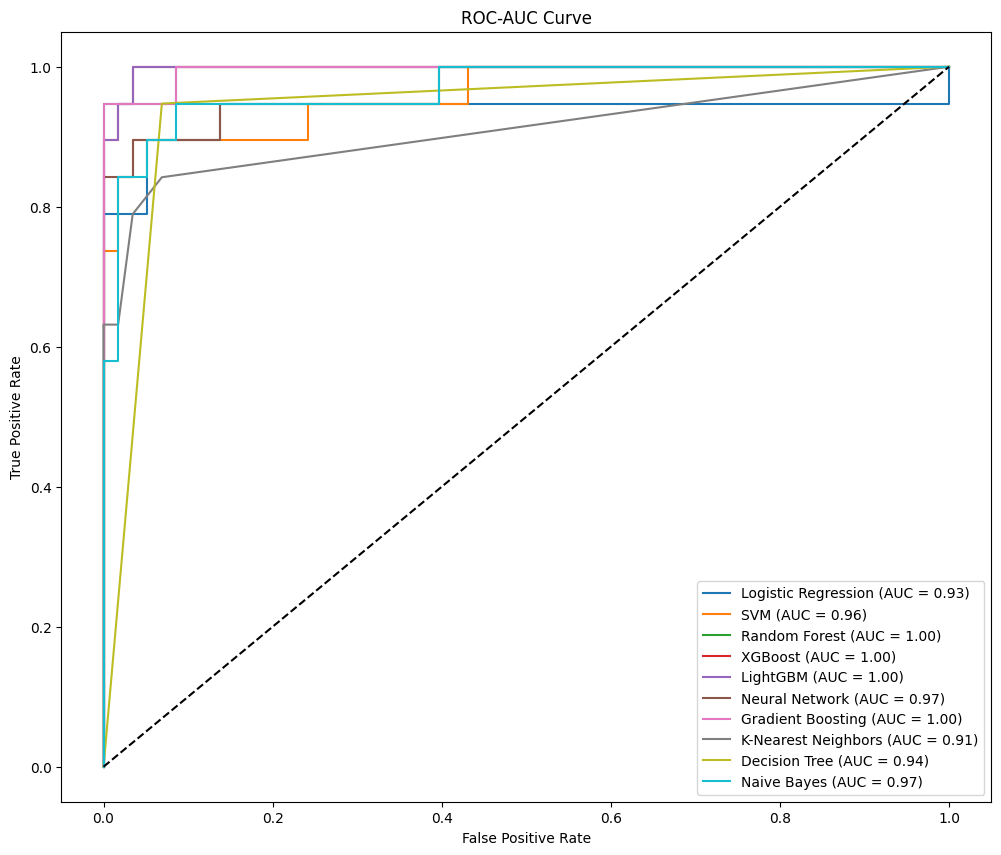

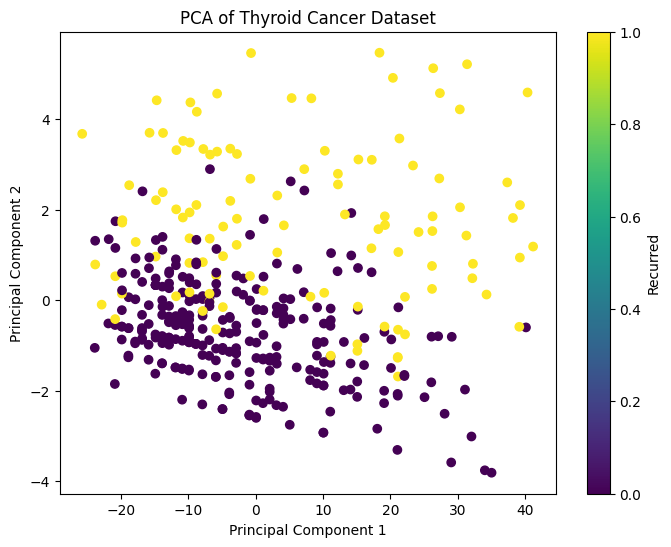

In [9]:
# Section 9: Plot ROC Curves
plt.figure(figsize=(12, 10))
for name, result in results.items():
    if result['roc_auc'] != 'N/A':
        fpr, tpr, _ = roc_curve(y_test, result['model'].predict_proba(X_test)[:, 1])
        plt.plot(fpr, tpr, label=f'{name} (AUC = {result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc='best')
plt.show()

# Section 10: PCA for Dimensionality Reduction and Plot
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
plt.colorbar(label='Recurred')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Thyroid Cancer Dataset')
plt.show()


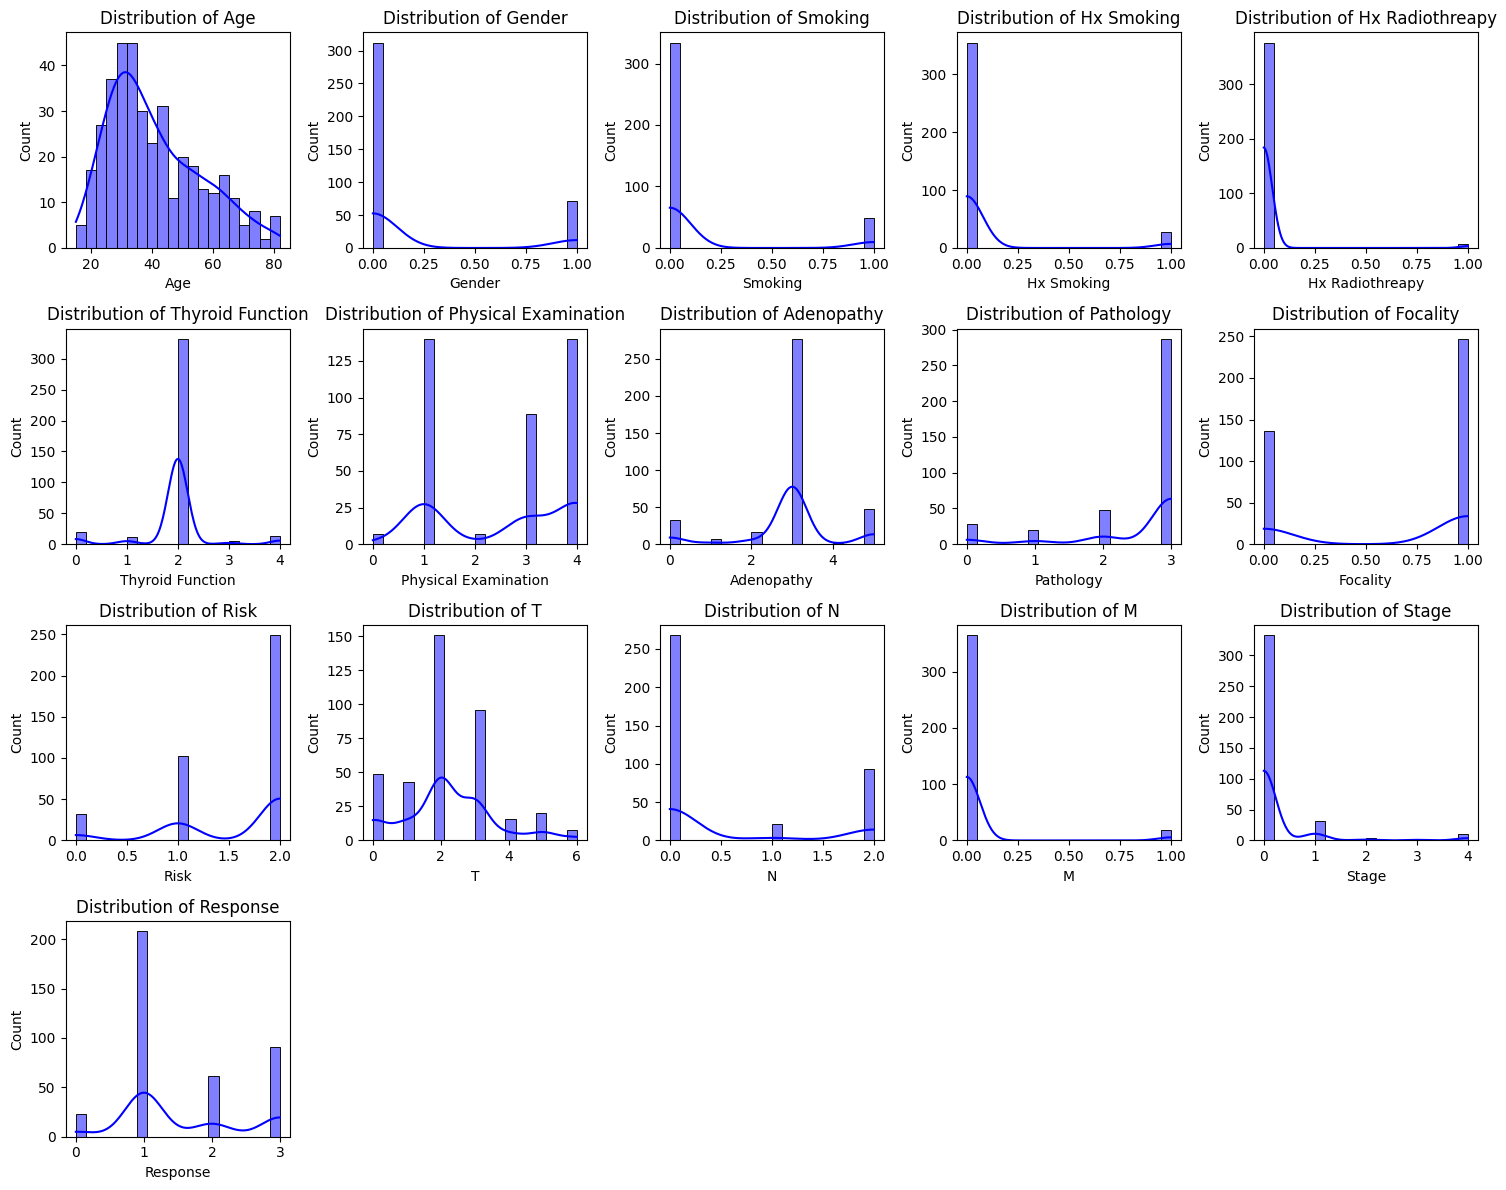

In [10]:
# Section 11: Histograms for Feature Distribution
plt.figure(figsize=(15, 12))
for i, column in enumerate(X.columns, 1):
    plt.subplot(4, 5, i)
    sns.histplot(data[column], kde=True, color='blue', bins=20)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()


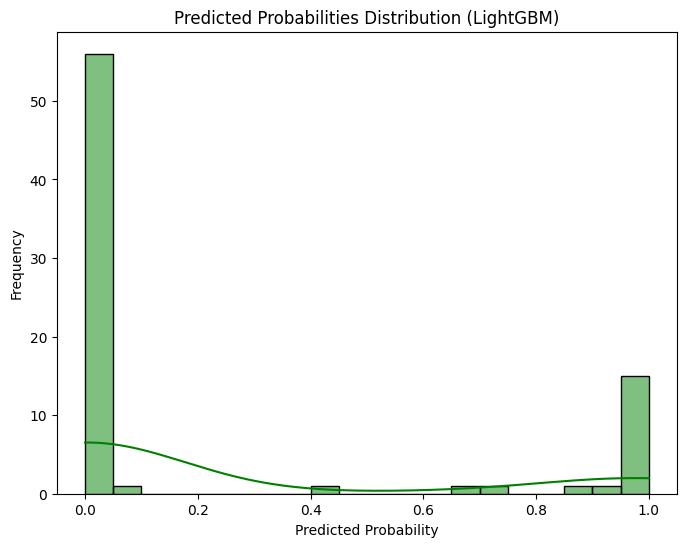

In [11]:
# Section 12: Histogram for Predicted Probabilities
best_model_name = max(results, key=lambda name: results[name]['roc_auc'])
best_model = results[best_model_name]['model']

if hasattr(best_model, "predict_proba"):
    y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]
    plt.figure(figsize=(8, 6))
    sns.histplot(y_pred_proba_best, bins=20, color='green', kde=True)
    plt.title(f'Predicted Probabilities Distribution ({best_model_name})')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.show()

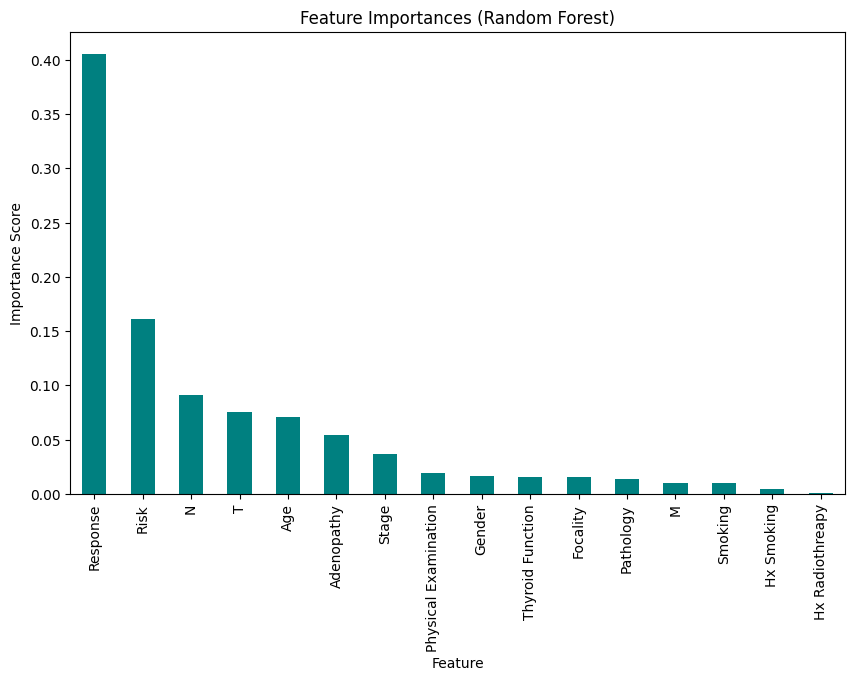

In [12]:
# Section 13: Bar Plot for Feature Importance (Example with Random Forest)
feature_importances = pd.Series(results['Random Forest']['model'].feature_importances_, index=X.columns)
plt.figure(figsize=(10, 6))
feature_importances.sort_values(ascending=False).plot(kind='bar', color='teal')
plt.title('Feature Importances (Random Forest)')
plt.xlabel('Feature')
plt.ylabel('Importance Score')
plt.show()


<ipython-input-13-9eebefaba334>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=accuracy_scores, palette='viridis')


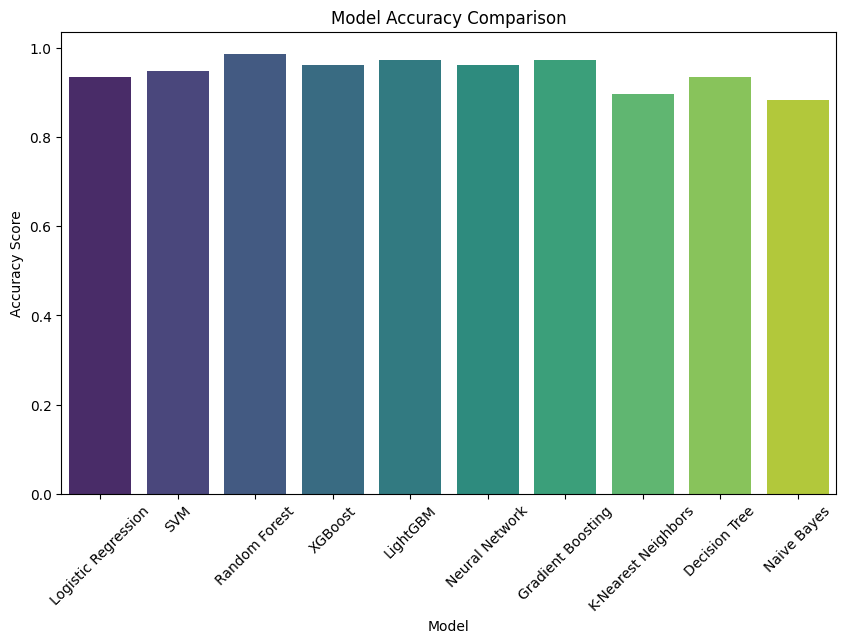

In [13]:
# Section 14: Bar Plot for Model Comparison
accuracy_scores = [result['accuracy'] for result in results.values()]
model_names = [name for name in results.keys()]

plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=accuracy_scores, palette='viridis')
plt.xticks(rotation=45)
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy Score')
plt.show()

In [ ]:
# Section 15: Precision-Recall Curve
plt.figure(figsize=(12, 8))
for name, result in results.items():
    if hasattr(result['model'], "predict_proba"):
        precision, recall, _ = precision_recall_curve(y_test, result['model'].predict_proba(X_test)[:, 1])
        plt.plot(recall, precision, label=f'{name}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()


# **Best Model Selection**

In [15]:
# Section 16: Save the Best Model
best_model = results[best_model_name]['model']
joblib.dump(best_model, 'best_thyroid_model.pkl')
print(f"Best Model: {best_model_name} saved successfully.")

# Section 17: Load and Evaluate the Saved Model
loaded_model = joblib.load('best_thyroid_model.pkl')
y_pred_best = loaded_model.predict(X_test)
y_pred_proba_best = loaded_model.predict_proba(X_test)[:, 1]
accuracy_best = accuracy_score(y_test, y_pred_best)
roc_auc_best = roc_auc_score(y_test, y_pred_proba_best)

print(f"Loaded Model Accuracy: {accuracy_best * 100:.2f}%")
print(f"Loaded Model ROC-AUC Score: {roc_auc_best:.2f}")
print(classification_report(y_test, y_pred_best))

Best Model: LightGBM saved successfully.
Loaded Model Accuracy: 97.40%
Loaded Model ROC-AUC Score: 1.00
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        58
           1       0.95      0.95      0.95        19

    accuracy                           0.97        77
   macro avg       0.97      0.97      0.97        77
weighted avg       0.97      0.97      0.97        77

